In [42]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

# Import all common libraries for models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Import libraries related to the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


### Loading the dataset

In [43]:
# Load the input csv file
df_songs = pd.read_csv("data/song_data.csv", delimiter=",")
df_songs.reset_index(drop=True)
df_songs.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

### Data Cleanup

In [44]:
# Merge the 2 dataframes
df_merged = df_songs

# Remove the song name
df_merged.drop("song_name", axis=1, inplace=True)

# Drop NA
df_merged.dropna(inplace=True)

df_merged.reset_index(drop=True)
df_merged.shape

(18835, 14)

In [45]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.2 MB


Define the datatypes of the fields correctly (numerical and categorical)

In [46]:
# Convert song duration to numeric types
df_merged["song_duration_ms"] = df_merged["song_duration_ms"].astype("float64")

# Category type
# Key encoding
df_merged["key"] = df_merged["key"].astype("category")

# Time Signature encoding
df_merged["time_signature"] = df_merged["time_signature"].astype("category")

# Audio Mode encoding
df_merged["audio_mode"] = df_merged["audio_mode"].astype("category")

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   song_popularity   18835 non-null  int64   
 1   song_duration_ms  18835 non-null  float64 
 2   acousticness      18835 non-null  float64 
 3   danceability      18835 non-null  float64 
 4   energy            18835 non-null  float64 
 5   instrumentalness  18835 non-null  float64 
 6   key               18835 non-null  category
 7   liveness          18835 non-null  float64 
 8   loudness          18835 non-null  float64 
 9   audio_mode        18835 non-null  category
 10  speechiness       18835 non-null  float64 
 11  tempo             18835 non-null  float64 
 12  time_signature    18835 non-null  category
 13  audio_valence     18835 non-null  float64 
dtypes: category(3), float64(10), int64(1)
memory usage: 1.8 MB


Remove the rows with popularity score, instrumentalness, tempo and time_signature = 0

In [47]:
# Remove the songs with popularity=0. This is due to spotify's internal algorithm and also the time when the data was extracted (a song could have just been released)
df_merged = df_merged[df_merged['song_popularity']>0]

# Remove songs that have instrumentalness and tempo as 0
df_merged = df_merged[(df_merged['instrumentalness']>0) & (df_merged['tempo']>0)]

# Drop the solo entry with time signature = 0
df_merged.drop(df_merged[df_merged['time_signature']==0].index, inplace=True)


### Classify top 30% songs as popular

In [48]:
# Classify top 30% songs as popular
df_temp = df_merged.sort_values('song_popularity',ascending=False).head(int(df_merged.shape[0]*.3))

# Take the last value
popularity_threshold = df_temp['song_popularity'].tail(1).values[0]
print("Popularity score threshold : ",popularity_threshold)

# df_temp['song_popularity'].tail(1) returns a numpy.series
# .values will then convert a series into array

Popularity score threshold :  63


In [49]:
# Assign popular=1 for songs that have a popularity score of >= 60. Else 0
df_merged['is_popular'] = np.where(df_merged['song_popularity']>=popularity_threshold, 1, 0)

df_merged.head()

song_popularity  song_duration_ms  acousticness  danceability  energy  \
0               73          262333.0      0.005520         0.496   0.682   
2               76          231733.0      0.008170         0.737   0.463   
3               74          216933.0      0.026400         0.451   0.970   
5               80          235893.0      0.008950         0.316   0.945   
6               81          199893.0      0.000504         0.581   0.887   

   instrumentalness key  liveness  loudness audio_mode  speechiness    tempo  \
0          0.000029   8    0.0589    -4.095          1       0.0294  167.060   
2          0.447000   0    0.2550    -7.828          1       0.0792  123.881   
3          0.003550   0    0.1020    -4.938          1       0.1070  122.444   
5          0.000002   4    0.3960    -3.169          0       0.1240  189.931   
6          0.001110   4    0.2680    -3.659          0       0.0624   90.578   

  time_signature  audio_valence  is_popular  
0              4          0.474           1  
2              4          0.324           1  
3              4          0.198           1  
5              4          0.320           1  
6              4          0.724           1

## Handling Outliers

In [50]:
df_merged.describe()

song_popularity  song_duration_ms  acousticness  danceability  \
count     11502.000000      1.150200e+04  11502.000000  11502.000000   
mean         51.185359      2.223621e+05      0.270938      0.619752   
std          20.370106      6.584289e+04      0.311289      0.162325   
min           1.000000      2.618600e+04      0.000001      0.059400   
25%          40.000000      1.861762e+05      0.015300      0.516000   
50%          54.000000      2.137195e+05      0.124000      0.632000   
75%          66.000000      2.493345e+05      0.477000      0.741000   
max          98.000000      1.799346e+06      0.996000      0.987000   

             energy  instrumentalness      liveness      loudness  \
count  11502.000000      11502.000000  11502.000000  11502.000000   
mean       0.635275          0.124624      0.174285     -8.083589   
std        0.231709          0.269480      0.140464      4.292172   
min        0.001070          0.000001      0.010900    -38.768000   
25%        0.482250          0.000022      0.091700     -9.905500   
50%        0.670000          0.000635      0.119000     -7.113000   
75%        0.823000          0.037700      0.209750     -5.179000   
max        0.999000          0.997000      0.986000      1.585000   

        speechiness         tempo  audio_valence    is_popular  
count  11502.000000  11502.000000   11502.000000  11502.000000  
mean       0.083544    120.791379       0.511950      0.312467  
std        0.084540     28.384838       0.255141      0.463519  
min        0.022400     46.591000       0.023000      0.000000  
25%        0.036400     99.076000       0.303000      0.000000  
50%        0.050000    120.014000       0.507000      0.000000  
75%        0.089400    138.028000       0.721000      1.000000  
max        0.915000    242.318000       0.982000      1.000000

Key observations:
  - song_duration_ms appears to be the only column where the max value seems significantly higher. It is worth checking outliers in the song duration.
  - instrumentalness has standard deviation that is nearly 2.2 times the mean value. This could be due to a significant number of songs being very high on vocal (rap, hip hop, etc) or purely instrumental. They might not be outliers as this could be a valid son composition.

Identify outliers in song duration column using the z-scores in the dataset and taking 3 as the threshold for removing any outliers.

In [51]:
# Check for outliers in song duration. All other columns seem to be in a decent range
df_merged["zscore"] = np.abs(zscore(df_merged['song_duration_ms']))
print(f'Original shape: {df_merged.shape}')

# Filter out the values with z score higher than 3
df_merged = df_merged[(df_merged.zscore>-3) & (df_merged.zscore<3)]
print(f'Shape after removing outliers in song duration : {df_merged.shape}')

df_merged["zscore"] = np.abs(zscore(df_merged['instrumentalness']))
df_merged = df_merged[(df_merged.zscore>-3) & (df_merged.zscore<3)]
print(f'Shape after removing outliers in instrumentalness: {df_merged.shape}')

# drop z-values
df_merged.drop("zscore", axis=1, inplace=True)
df_merged.head()

Original shape: (11502, 16)
Shape after removing outliers in song duration : (11366, 16)
Shape after removing outliers in instrumentalness: (11123, 16)


song_popularity  song_duration_ms  acousticness  danceability  energy  \
0               73          262333.0      0.005520         0.496   0.682   
2               76          231733.0      0.008170         0.737   0.463   
3               74          216933.0      0.026400         0.451   0.970   
5               80          235893.0      0.008950         0.316   0.945   
6               81          199893.0      0.000504         0.581   0.887   

   instrumentalness key  liveness  loudness audio_mode  speechiness    tempo  \
0          0.000029   8    0.0589    -4.095          1       0.0294  167.060   
2          0.447000   0    0.2550    -7.828          1       0.0792  123.881   
3          0.003550   0    0.1020    -4.938          1       0.1070  122.444   
5          0.000002   4    0.3960    -3.169          0       0.1240  189.931   
6          0.001110   4    0.2680    -3.659          0       0.0624   90.578   

  time_signature  audio_valence  is_popular  
0              4          0.474           1  
2              4          0.324           1  
3              4          0.198           1  
5              4          0.320           1  
6              4          0.724           1

In [52]:
df_merged.reset_index(drop=True) # This statement resets the index and removes the rows with NaN values. This can be handled in several other ways, which are no included in scope for this notebook
df_merged.describe()

song_popularity  song_duration_ms  acousticness  danceability  \
count     11123.000000      11123.000000  11123.000000  11123.000000   
mean         51.263418     219788.740448      0.260371      0.623019   
std          20.495192      53166.997108      0.301847      0.159976   
min           1.000000      50508.000000      0.000001      0.059400   
25%          40.000000     187019.500000      0.014900      0.521000   
50%          54.000000     213626.000000      0.117000      0.634000   
75%          66.000000     248024.000000      0.450000      0.742000   
max          98.000000     419500.000000      0.996000      0.987000   

             energy  instrumentalness      liveness      loudness  \
count  11123.000000      11123.000000  11123.000000  11123.000000   
mean       0.643437          0.104359      0.174700     -7.841723   
std        0.223871          0.240451      0.140192      3.898300   
min        0.001630          0.000001      0.011900    -36.729000   
25%        0.493000          0.000021      0.091650     -9.685000   
50%        0.675000          0.000522      0.119000     -7.024000   
75%        0.825000          0.026100      0.213000     -5.128000   
max        0.999000          0.924000      0.986000      1.585000   

        speechiness         tempo  audio_valence    is_popular  
count  11123.000000  11123.000000   11123.000000  11123.000000  
mean       0.083763    121.111204       0.517071      0.316641  
std        0.084338     28.207594       0.253418      0.465187  
min        0.022400     46.591000       0.023000      0.000000  
25%        0.036300     99.808500       0.310500      0.000000  
50%        0.049900    120.026000       0.511000      0.000000  
75%        0.090100    138.161000       0.724500      1.000000  
max        0.915000    242.318000       0.982000      1.000000

### Scaling the dataset

In [53]:
# Divide the dataset into input and output
df_merged.reset_index(drop=True)
#X = df_merged.drop("is_popular", axis=1)
X = df_merged
y = df_merged["is_popular"]

# Normalise the numerical columns in the dataset
numerical = ["song_duration_ms","acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","audio_valence"]
print(numerical)
scaler = MinMaxScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# Round all values to 6 decimals places
X[numerical].round(6)

# Print X
X.head()

['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


song_popularity  song_duration_ms  acousticness  danceability    energy  \
0               73          0.574064      0.005541      0.470677  0.682164   
2               76          0.491135      0.008201      0.730487  0.462587   
3               74          0.451026      0.026505      0.422165  0.970924   
5               80          0.502409      0.008985      0.276628  0.945858   
6               81          0.404846      0.000505      0.562311  0.887705   

   instrumentalness key  liveness  loudness audio_mode  speechiness     tempo  \
0      3.073596e-05   8  0.048250  0.851751          1     0.007842  0.615495   
2      4.837657e-01   0  0.249564  0.754320          1     0.063634  0.394887   
3      3.840913e-03   0  0.092496  0.829749          1     0.094779  0.387545   
5      9.199144e-07   4  0.394313  0.875920          0     0.113825  0.732347   
6      1.200218e-03   4  0.262909  0.863131          0     0.044813  0.224736   

  time_signature  audio_valence  is_popular  
0              4       0.470282           1  
2              4       0.313869           1  
3              4       0.182482           1  
5              4       0.309698           1  
6              4       0.730970           1

### Encode the Categorical variables

Categorical encoding is used to encode the categorical variables - 'key', 'audio_mode', and 'time_signature'.

In [54]:
# Encode categorical variables with Category encode
categorical = ["key", "time_signature", "audio_mode"]

for item in categorical:
    # X[item] = X[item].astype("category").cat.codes
    X[item] = X[item].astype("category").cat.codes

X.head()

song_popularity  song_duration_ms  acousticness  danceability    energy  \
0               73          0.574064      0.005541      0.470677  0.682164   
2               76          0.491135      0.008201      0.730487  0.462587   
3               74          0.451026      0.026505      0.422165  0.970924   
5               80          0.502409      0.008985      0.276628  0.945858   
6               81          0.404846      0.000505      0.562311  0.887705   

   instrumentalness  key  liveness  loudness  audio_mode  speechiness  \
0      3.073596e-05    8  0.048250  0.851751           1     0.007842   
2      4.837657e-01    0  0.249564  0.754320           1     0.063634   
3      3.840913e-03    0  0.092496  0.829749           1     0.094779   
5      9.199144e-07    4  0.394313  0.875920           0     0.113825   
6      1.200218e-03    4  0.262909  0.863131           0     0.044813   

      tempo  time_signature  audio_valence  is_popular  
0  0.615495               3       0.470282           1  
2  0.394887               3       0.313869           1  
3  0.387545               3       0.182482           1  
5  0.732347               3       0.309698           1  
6  0.224736               3       0.730970           1

In [55]:
X.describe()

song_popularity  song_duration_ms  acousticness  danceability  \
count     11123.000000      11123.000000  11123.000000  11123.000000   
mean         51.263418          0.458765      0.261416      0.607610   
std          20.495192          0.144087      0.303060      0.172462   
min           1.000000          0.000000      0.000000      0.000000   
25%          40.000000          0.369958      0.014958      0.497628   
50%          54.000000          0.442064      0.117469      0.619448   
75%          66.000000          0.535285      0.451806      0.735878   
max          98.000000          1.000000      1.000000      1.000000   

             energy  instrumentalness           key      liveness  \
count  11123.000000      11123.000000  11123.000000  11123.000000   
mean       0.643499          0.112942      5.293536      0.167128   
std        0.224461          0.260229      3.595270      0.143920   
min        0.000000          0.000000      0.000000      0.000000   
25%        0.492666          0.000021      2.000000      0.081870   
50%        0.675146          0.000564      6.000000      0.109948   
75%        0.825541          0.028246      8.000000      0.206447   
max        1.000000          1.000000     11.000000      1.000000   

           loudness    audio_mode   speechiness         tempo  time_signature  \
count  11123.000000  11123.000000  11123.000000  11123.000000    11123.000000   
mean       0.753961      0.633282      0.068746      0.380735        2.955947   
std        0.101746      0.481930      0.094486      0.144117        0.266585   
min        0.000000      0.000000      0.000000      0.000000        1.000000   
25%        0.705852      0.000000      0.015572      0.271897        3.000000   
50%        0.775304      1.000000      0.030809      0.375191        3.000000   
75%        0.824790      1.000000      0.075846      0.467846        3.000000   
max        1.000000      1.000000      1.000000      1.000000        4.000000   

       audio_valence    is_popular  
count   11123.000000  11123.000000  
mean        0.515193      0.316641  
std         0.264252      0.465187  
min         0.000000      0.000000  
25%         0.299791      0.000000  
50%         0.508863      0.000000  
75%         0.731491      1.000000  
max         1.000000      1.000000

## Exploratory Data Analysis (EDA)

#### Part 1 - Numerical Fields


EDA 1.1 - Correlation between numerical fields

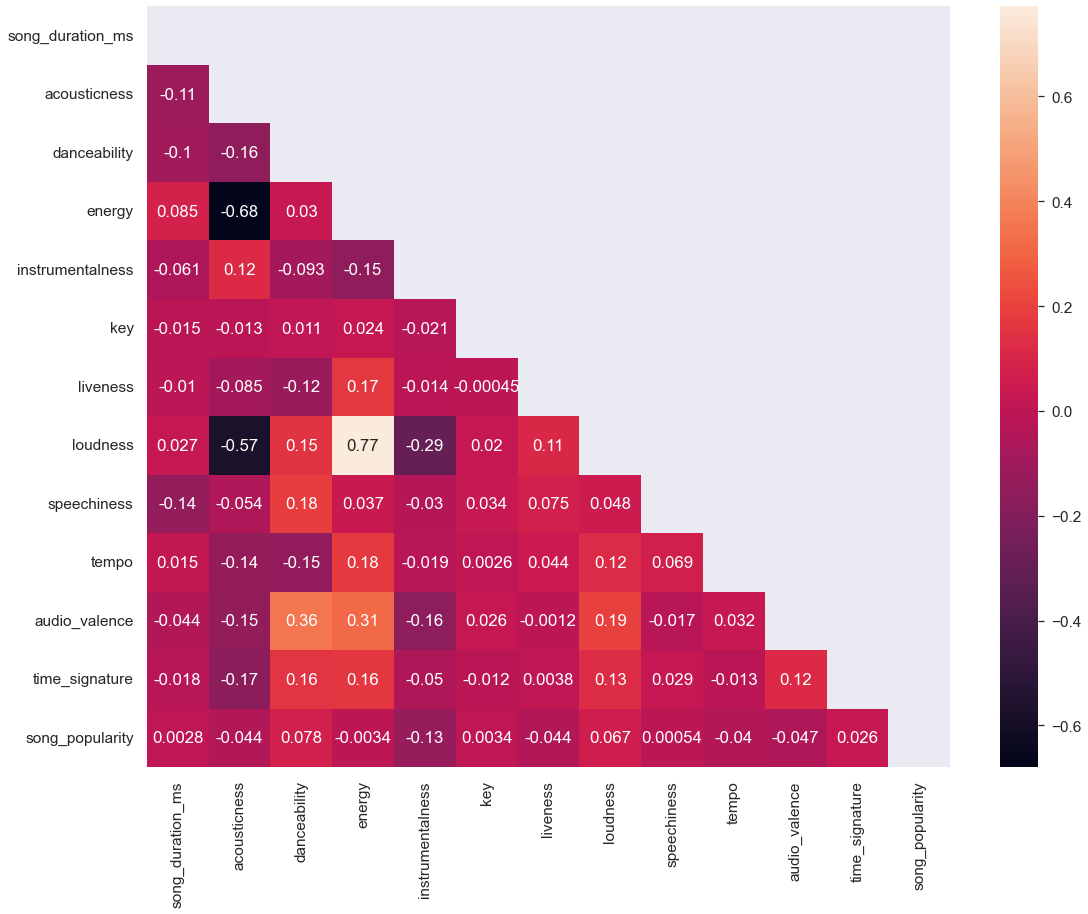

In [56]:
numerical_with_output = ["song_duration_ms","acousticness","danceability","energy", "instrumentalness", "key", "liveness","loudness","speechiness","tempo","audio_valence", "time_signature", "song_popularity"]

matrix = np.triu(df_merged[numerical_with_output].corr())
fig, ax = plt.subplots(figsize=(18,14))
sns.set(font_scale=1.4)
sns.heatmap(df_merged[numerical_with_output].corr(), annot=True, ax=ax, mask=matrix);

EDA 1.2 - Histograms for popular songs

Observations:
  - Data suggests that people tend to prefer songs that are louder, with beats and vocals, and are dance numbers with high energy.
  - danceability, energy, loudness are all left skewed. This is intuitive too as these are typically the fast paced, high energy dance numbers
  - accousticness and instrumentalness are highly right skewed, implying that majority of the songs are not acoustic (have multiple instruments, beats) and have vocals

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

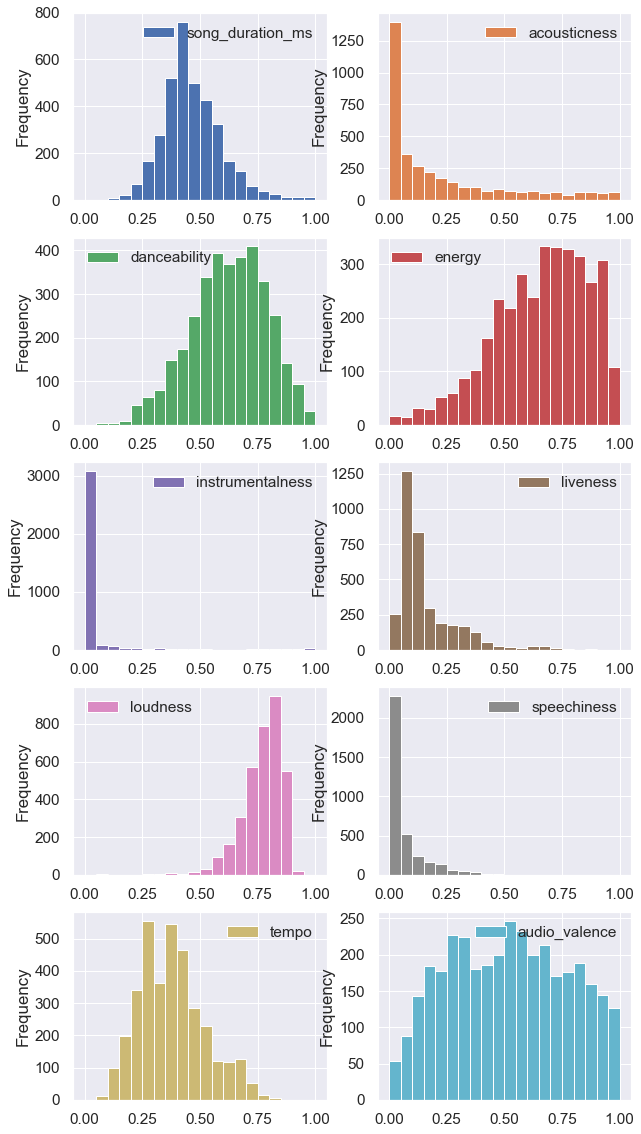

In [57]:
# Plot all the numerical columns as histograms
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,20))
sns.set(font_scale=1.4)
X_popular = X[X['is_popular']==1]
X_popular[numerical].plot.hist(subplots=True, legend=True, layout=(5, 2), bins=20, ax=ax)

EDA 1.3 - Histograms for songs that are not popular

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

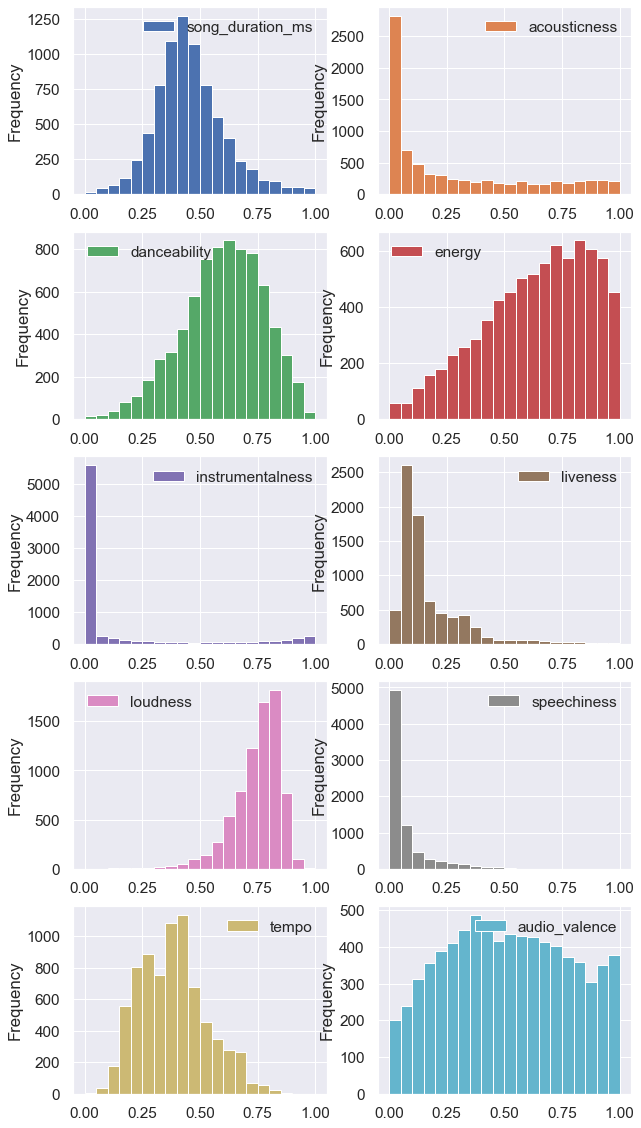

In [58]:
# Plot all the numerical columns as histograms
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,20))
sns.set(font_scale=1.4)
X_not_popular = X[X['is_popular']==0]
X_not_popular[numerical].plot.hist(subplots=True, legend=True, layout=(5, 2), bins=20, ax=ax)

EDA 1.3 - Loudness and Popularity

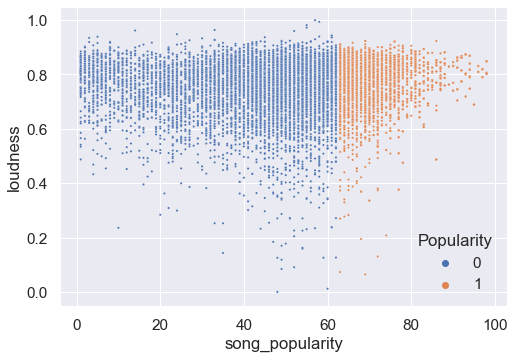

In [59]:
sns.scatterplot(data=df_merged, x='song_popularity', y='loudness', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [60]:
loudness_all = round(df_merged['loudness'].mean(), 4)
loudness_pop = round(df_merged[df_merged['is_popular']==1]['loudness'].mean(), 4)
loudness_unpop = round(df_merged[df_merged['is_popular']==0]['loudness'].mean(), 4)
print("Mean loudness of all songs: ", loudness_all)
print("Mean loudness of popular songs: ", loudness_pop)
print("Mean loudness of songs not popular: ", loudness_unpop)

Mean loudness of all songs:  0.754
Mean loudness of popular songs:  0.7687
Mean loudness of songs not popular:  0.7472


EDA 1.4 - Energy and Popularity

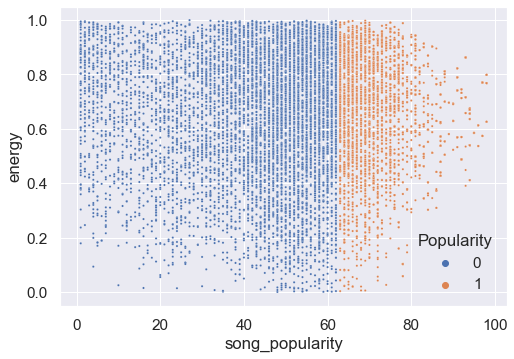

In [61]:
sns.scatterplot(data=df_merged, x='song_popularity', y='energy', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [62]:
energy_all = round(df_merged['energy'].mean(), 4)
energy_pop = round(df_merged[df_merged['is_popular']==1]['energy'].mean(), 4)
energy_unpop = round(df_merged[df_merged['is_popular']==0]['energy'].mean(), 4)
print("Mean energy of all songs: ", energy_all)
print("Mean energy of popular songs: ", energy_pop)
print("Mean energy of songs not popular: ", energy_unpop)

Mean energy of all songs:  0.6435
Mean energy of popular songs:  0.6573
Mean energy of songs not popular:  0.6371


EDA 1.5 - Danceability and Popularity

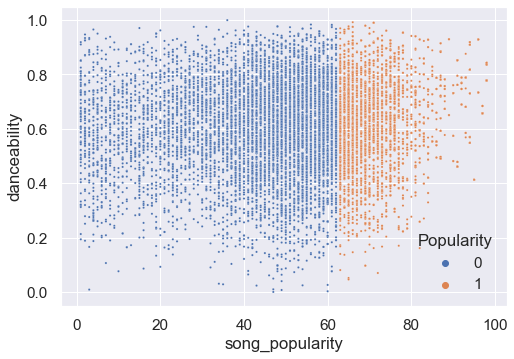

In [63]:
sns.scatterplot(data=df_merged, x='song_popularity', y='danceability', hue='is_popular', s=5)
plt.legend(loc='lower right', title='Popularity')
plt.show()

In [64]:
danceability_all = round(df_merged['danceability'].mean(), 4)
danceability_pop = round(df_merged[df_merged['is_popular']==1]['danceability'].mean(), 4)
danceability_unpop = round(df_merged[df_merged['is_popular']==0]['danceability'].mean(), 4)
print("Mean danceability of all songs: ", danceability_all)
print("Mean danceability of popular songs: ", danceability_pop)
print("Mean danceability of songs not popular: ", danceability_unpop)

Mean danceability of all songs:  0.6076
Mean danceability of popular songs:  0.6249
Mean danceability of songs not popular:  0.5996


EDA 1.6 Audio valence for top 500 most popular songs

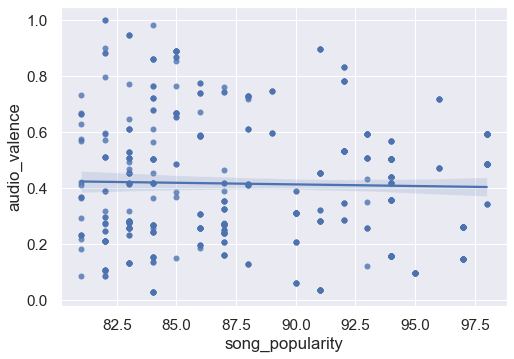

In [65]:
# Classify top 30% songs as popular
df_temp = df_merged.sort_values('song_popularity',ascending=False).head(500)

sns.regplot(data=df_temp, x='song_popularity', y='audio_valence')
plt.show()

In [66]:
valence_all = round(df_merged['audio_valence'].mean(), 4)
valence_pop = round(df_merged[df_merged['is_popular']==1]['audio_valence'].mean(), 4)
valence_top500 = round(df_temp['audio_valence'].mean(), 4)
print("Mean audio valence of all songs: ", valence_all)
print("Mean audio valence of popular songs: ", valence_pop)
print("Mean audio valence of top 500 songs: ", valence_top500)

Mean audio valence of all songs:  0.5152
Mean audio valence of popular songs:  0.5163
Mean audio valence of top 500 songs:  0.4133


EDA 1.7 - Pairplot with all features

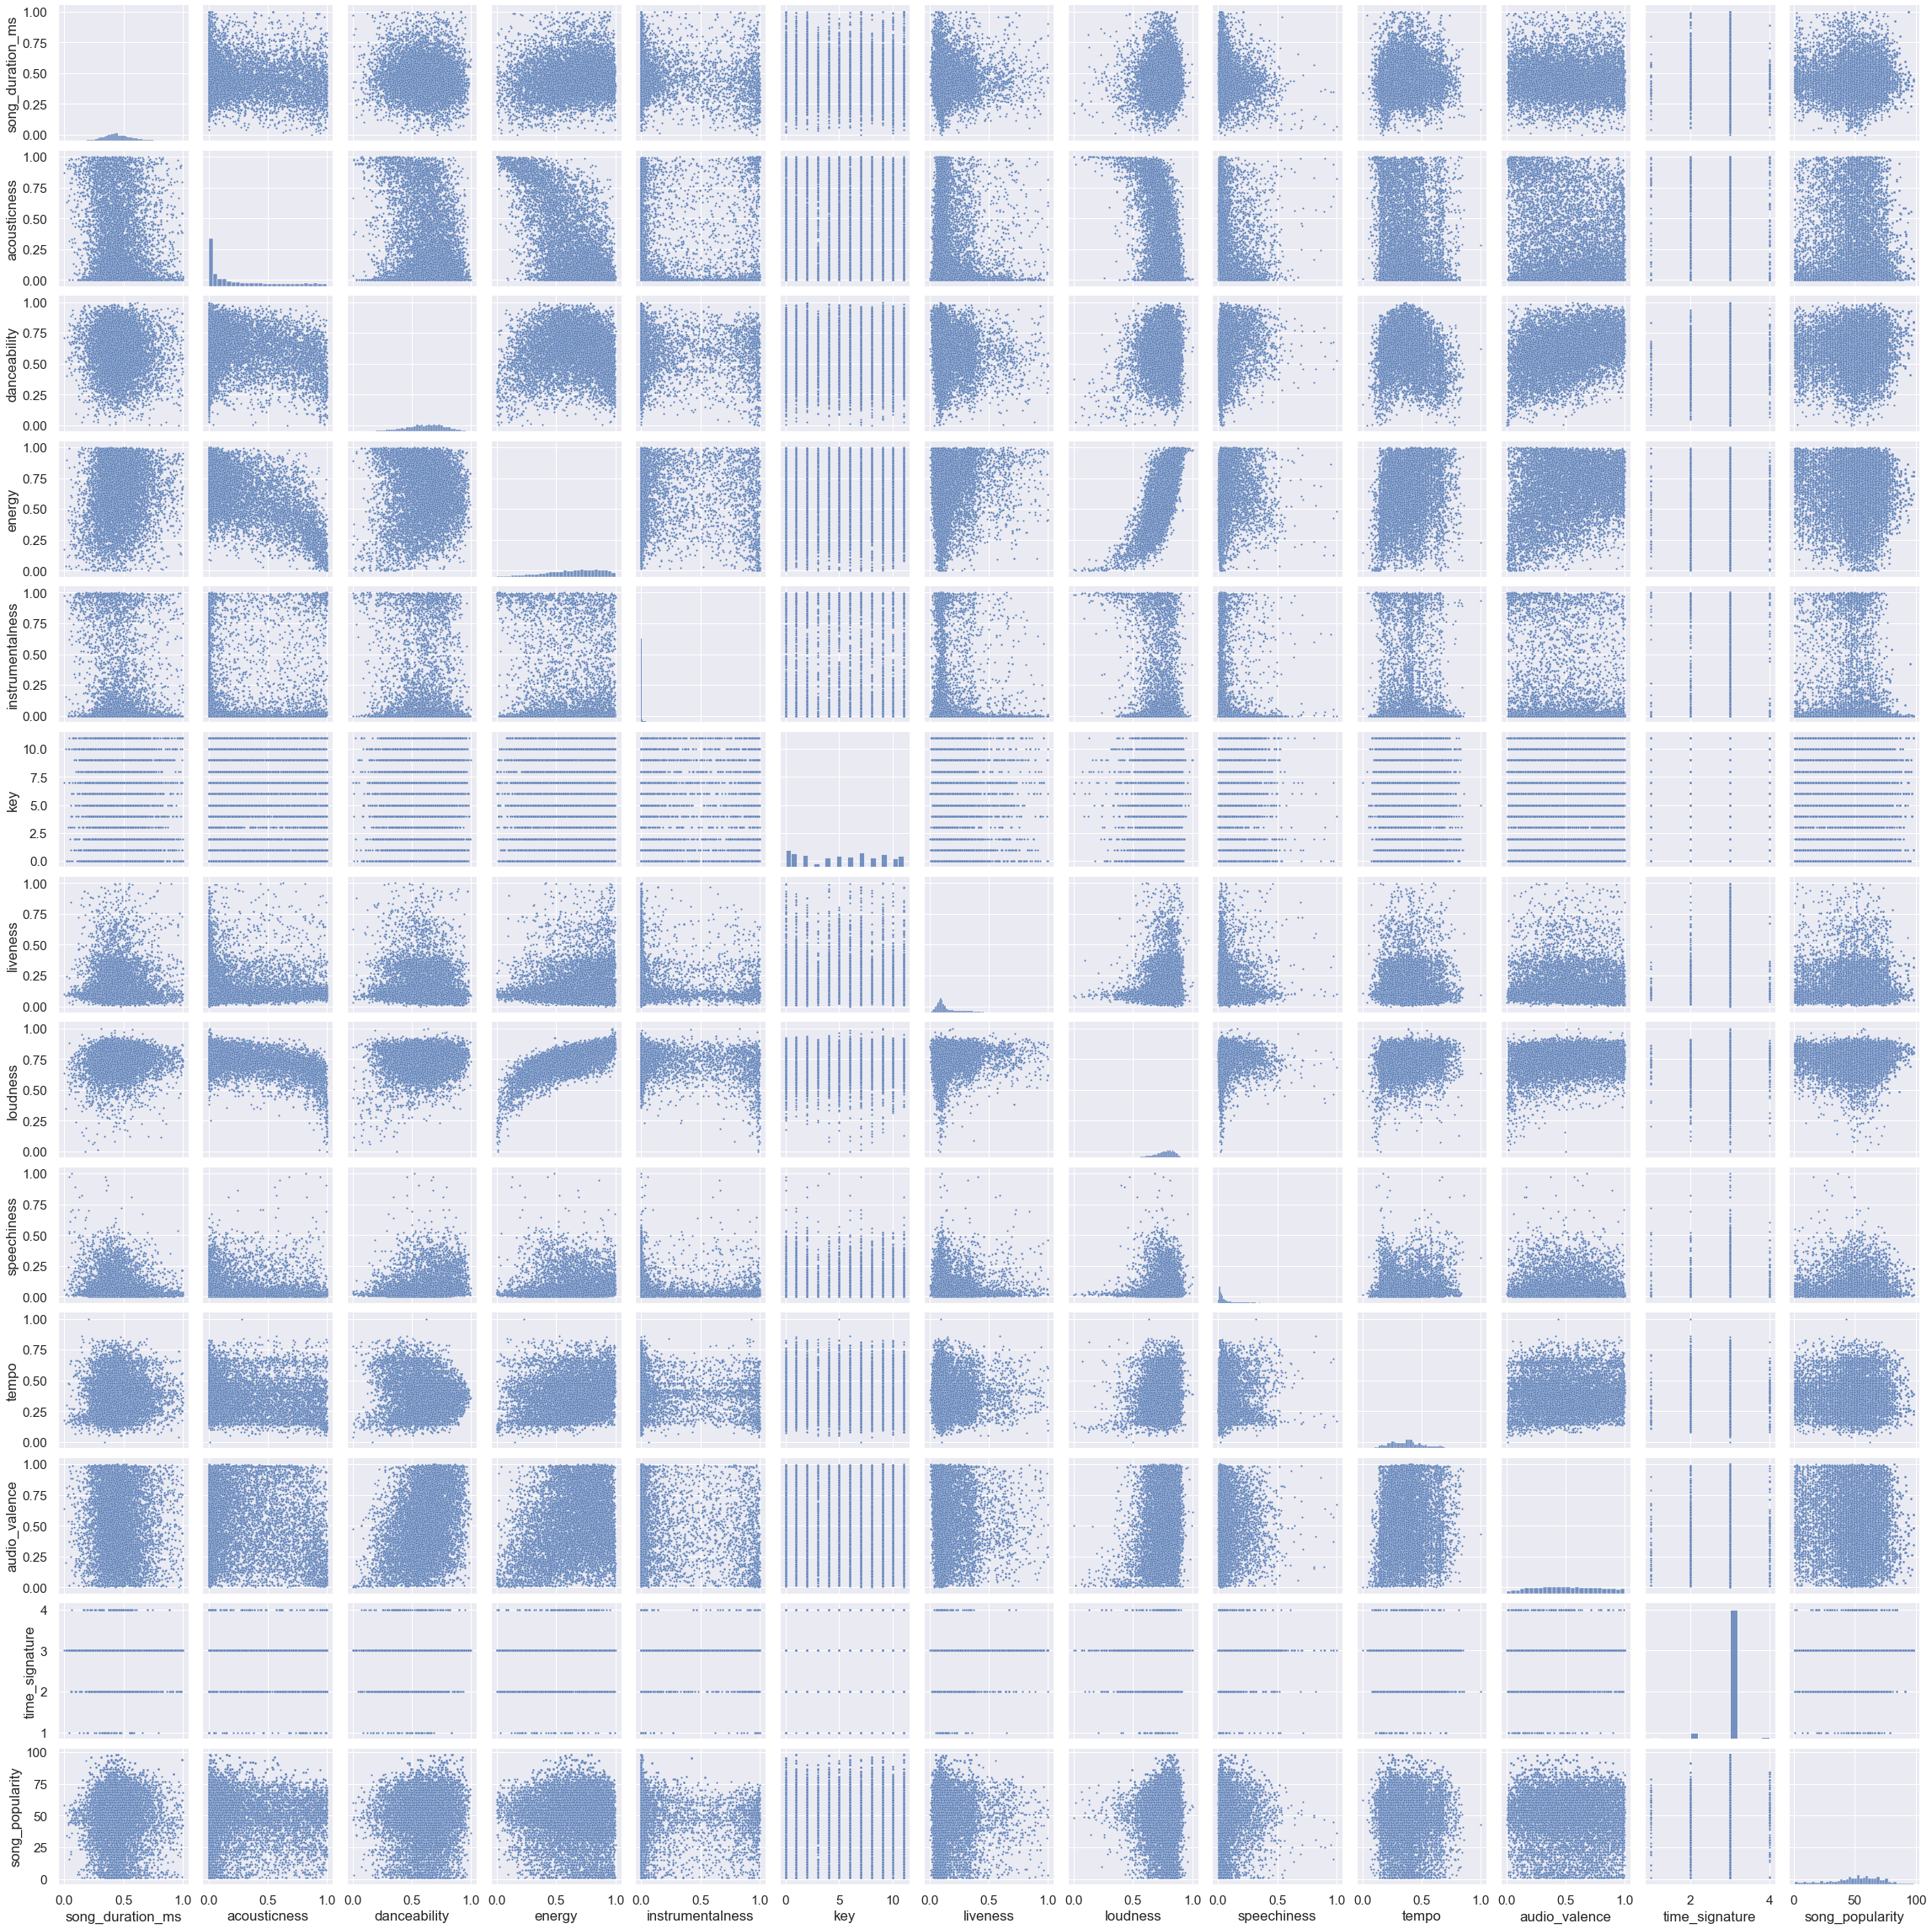

In [67]:
plt.figsize=(10,10)
sns.pairplot(df_merged[numerical_with_output], plot_kws={"s": 5})


Observations:
  - Linear models might not be ideal for modeling as there does not seem to be any linear relationships between variables and the song popularity score

### Part 2 - Categorical Fields

EDA 2.1 - Distribution of songs by keys

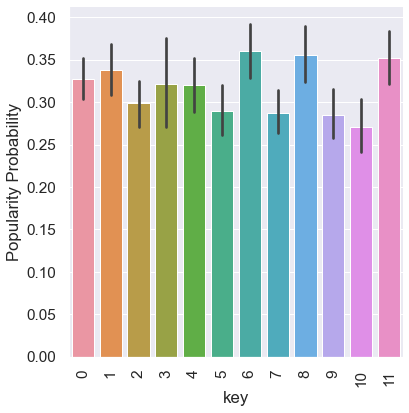

In [68]:
g = sns.catplot(x = "key", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.xticks(rotation=90)
plt.show()

Songs with keys 6, 8, 11 have higher probability of becoming popular

EDA 2.2 - Distribution of songs by time_signature

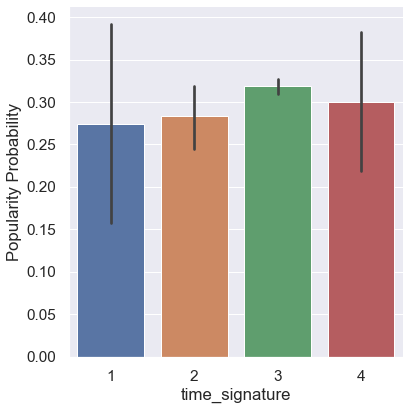

In [69]:
g = sns.catplot(x = "time_signature", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.show()

EDA 2.3 - Distribution of songs by audio mode

In [70]:
df_merged['time_signature'].value_counts()

3    10464
2      498
4      110
1       51
Name: time_signature, dtype: int64

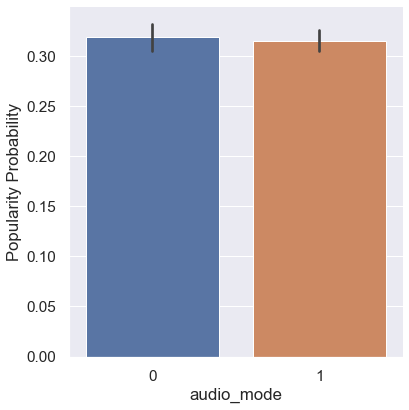

In [71]:
g = sns.catplot(x = "audio_mode", y = "is_popular", data = df_merged, kind = "bar", height = 6)
g.set_ylabels("Popularity Probability")
plt.show()

## Split into training and testing sets

In [72]:
# Drop Song Popularity column as the output is now a binary class 'is_popular'
X.drop(['song_popularity', 'is_popular'], axis=1, inplace=True)

In [73]:
y.head()

0    1
2    1
3    1
5    1
6    1
Name: is_popular, dtype: int64

In [74]:
random_state=42

# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

y_train.head()

X_train:  (7786, 13)
X_test:  (3337, 13)
y_train:  (7786,)
y_test:  (3337,)


10623    0
5442     0
5644     0
10297    1
15359    0
Name: is_popular, dtype: int64

## Handling imbalance in the dataset using SMOTE

In [75]:
# Before SMOTE
y_train.value_counts()

0    5321
1    2465
Name: is_popular, dtype: int64

In [76]:
#X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
smote = SMOTE(sampling_strategy='minority', random_state=random_state)

# Get indices of the categorical features
#categorical_features_indices = np.where(X.dtypes == 'int64')[0]
#categorical_features_indices = []
#for col in categorical:
#    categorical_features_indices.append(X_train.columns.get_loc(col))

# Use SMOTENC since it handles sampling of categorical feautures
#smote = SMOTENC(categorical_features=categorical_features_indices, random_state=random_state)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()

0    5321
1    5321
Name: is_popular, dtype: int64

## Functions for the models

In [77]:
# Assign the model to the model name
def assign_model(model_name, k):
    if model_name == "Logistic Regression":
        model = LogisticRegression(solver='liblinear')

    elif model_name == "SVM":
        model = SVC(gamma='scale', probability=True)

    elif model_name == "K-Nearest Neighbors":
        model = KNeighborsClassifier(n_neighbors=k)

    elif model_name == "Naive Bayes":
        model = GaussianNB()

    elif model_name == "Ada Boost":
        model = AdaBoostClassifier(random_state=random_state)

    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=random_state)

    elif model_name == "Gradient Tree Boosting":
        model = GradientBoostingClassifier(random_state=random_state)

    elif model_name == "XG Boost":
        model = XGBClassifier(random_state=random_state, nthread=4, objective='binary:logistic', use_label_encoder=False)

    elif model_name == "LightGBM":
        model = LGBMClassifier(random_state=random_state)

    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=random_state)
    # For each model, define the module

    return model

In [82]:
# Create model
def create_model(model_name, knn_k):
    # For each model, define the module and the parameter grid to find the best parameters
    model = assign_model(model_name, knn_k)

    # Fit the model with training data
    if model_name == "LightGBM":
        model.fit(X_train, y_train, categorical_feature=categorical)
    elif model_name == "XG Boost":
        model.fit(X_train, y_train, eval_metric='rmse')
    else:
        model.fit(X_train, y_train)

    # Predict the output on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    acc_score = round(accuracy_score(y_test, y_pred),4)

    # Calculate CV result
    cv_result = cross_val_score(model, X_train, y_train, cv=10)

    return model, acc_score, cv_result, y_pred

In [79]:
# Plot ROC Curve and return ROC score
def plot_roc_curve(model):

    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    auc_score = round(auc(fpr, tpr), 4)
    print(f'\nROC AUC: \n{auc_score}')
    model_auc_list.append(auc_score)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,color="red")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()


In [80]:
# Create the model and print the results
def model_result(model_name, knn_k=5):
    model, acc_model, cv_result, y_pred = create_model(model_name, knn_k)

    # Get confusion matrix
    cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Get classification report
    cr_model = classification_report(y_true=y_test, y_pred=y_pred)

    # Print the model results
    print(f'\n ***** Model: {model_name} *****')
    print(f'\n ***** Model: {model} *****')
    print(f'\nModel Accuracy: \n{acc_model*100}%')
    print(f'\nCV Result: \n{cv_result}')
    print(f'\nAverage CV Score: \n{round(np.average(cv_result), 4)}')
    print('\nConfusion matrix: \n',cm_model)
    print('\nClassification report: \n',cr_model)

    sns.heatmap(cm_model,annot=True,fmt="d")
    plt.show()

    # Get ROC Score and plot the curve
    plot_roc_curve(model)

    # Add to the list
    model_names_list.append(model_name)
    model_accuracy_list.append(acc_model)
    model_cv_list.append(round(np.average(cv_result), 4))

    print("\n ***** End of model ***** \n")

In [81]:
# Create empty list to store the results
model_accuracy_list = []
model_names_list = []
model_cv_list = []
model_auc_list = []

### Model 1: Logistic Regression


 ***** Model: Logistic Regression *****

 ***** Model: LogisticRegression(solver='liblinear') *****

Model Accuracy: 
55.47%

CV Result: 
[0.60469484 0.58779343 0.57800752 0.58740602 0.6193609  0.6156015
 0.6137218  0.61654135 0.60902256 0.59398496]

Average CV Score: 
0.6026

Confusion matrix: 
 [[1072 1208]
 [ 278  779]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.47      0.59      2280
           1       0.39      0.74      0.51      1057

    accuracy                           0.55      3337
   macro avg       0.59      0.60      0.55      3337
weighted avg       0.67      0.55      0.57      3337



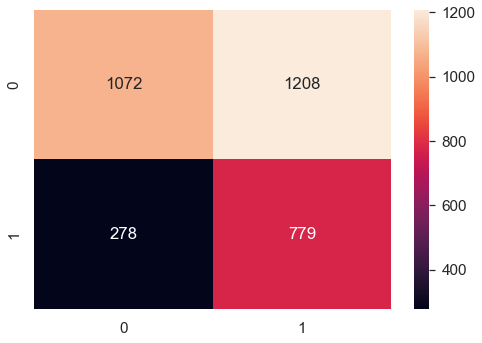


ROC AUC: 
0.6238


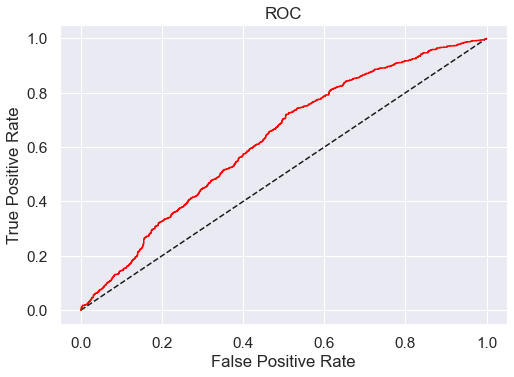


 ***** End of model ***** 



In [84]:
model_result("Logistic Regression")

### Model 2: Support Vector Machines


 ***** Model: SVM *****

 ***** Model: SVC(probability=True) *****

Model Accuracy: 
47.77%

CV Result: 
[0.57652582 0.58591549 0.56484962 0.58552632 0.58928571 0.60150376
 0.57330827 0.58552632 0.60244361 0.57706767]

Average CV Score: 
0.5842

Confusion matrix: 
 [[ 678 1602]
 [ 141  916]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.30      0.44      2280
           1       0.36      0.87      0.51      1057

    accuracy                           0.48      3337
   macro avg       0.60      0.58      0.48      3337
weighted avg       0.68      0.48      0.46      3337



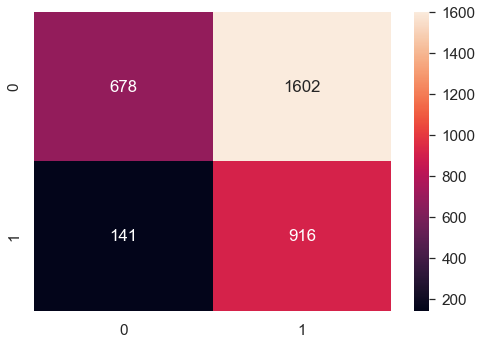


ROC AUC: 
0.6221


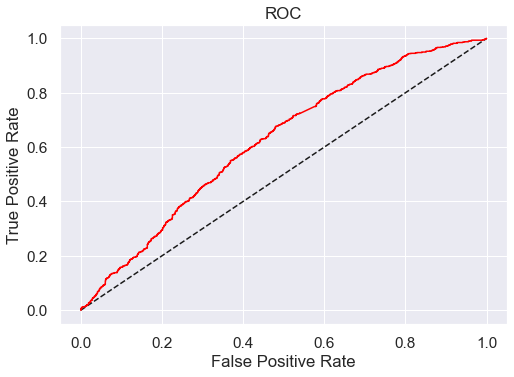


 ***** End of model ***** 



In [92]:
model_result("SVM")

### Model 3: Naive Bayes


 ***** Model: Naive Bayes *****

 ***** Model: GaussianNB() *****

Model Accuracy: 
50.43%

CV Result: 
[0.56431925 0.58215962 0.56203008 0.58082707 0.6137218  0.6212406
 0.59022556 0.62781955 0.60996241 0.60150376]

Average CV Score: 
0.5954

Confusion matrix: 
 [[ 852 1428]
 [ 226  831]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.37      0.51      2280
           1       0.37      0.79      0.50      1057

    accuracy                           0.50      3337
   macro avg       0.58      0.58      0.50      3337
weighted avg       0.66      0.50      0.51      3337



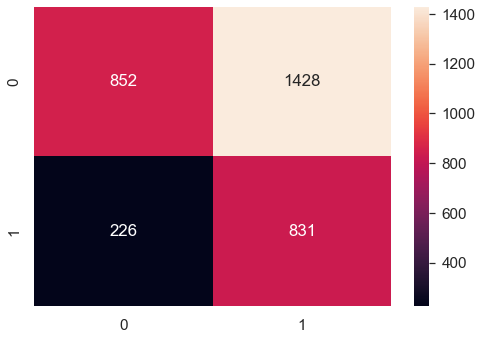


ROC AUC: 
0.6185


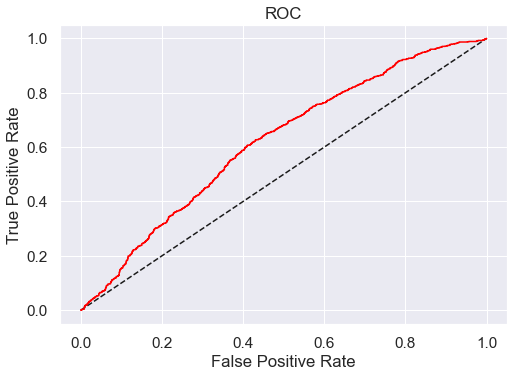


 ***** End of model ***** 



In [85]:
model_result("Naive Bayes")

### Model 4: K-Nearest Neighbors


 ***** Model: K-Nearest Neighbors *****

 ***** Model: KNeighborsClassifier() *****

Model Accuracy: 
62.660000000000004%

CV Result: 
[0.68450704 0.69014085 0.67763158 0.70582707 0.73684211 0.76221805
 0.76315789 0.7556391  0.75281955 0.7593985 ]

Average CV Score: 
0.7288

Confusion matrix: 
 [[1343  937]
 [ 309  748]]

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.59      0.68      2280
           1       0.44      0.71      0.55      1057

    accuracy                           0.63      3337
   macro avg       0.63      0.65      0.61      3337
weighted avg       0.70      0.63      0.64      3337



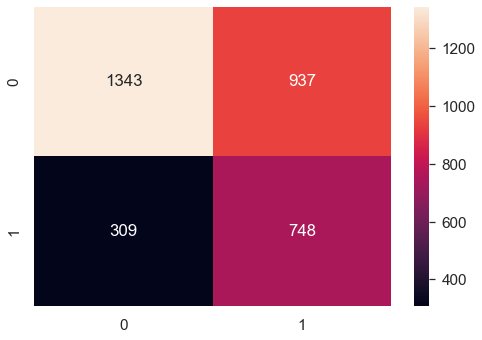


ROC AUC: 
0.7095


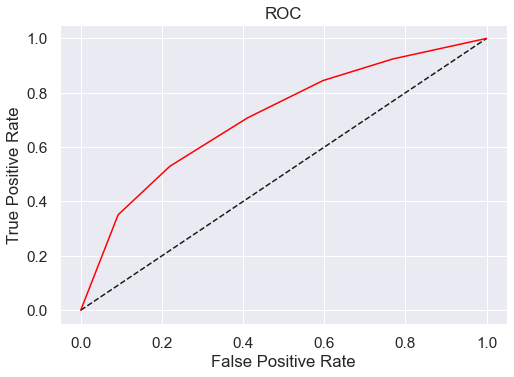


 ***** End of model ***** 



In [86]:
model_result("K-Nearest Neighbors")

### Model 5: Decision Trees


 ***** Model: Decision Tree *****

 ***** Model: DecisionTreeClassifier(random_state=42) *****

Model Accuracy: 
70.50999999999999%

CV Result: 
[0.72018779 0.74741784 0.7462406  0.73214286 0.7406015  0.77725564
 0.73120301 0.74718045 0.7537594  0.7537594 ]

Average CV Score: 
0.745

Confusion matrix: 
 [[1613  667]
 [ 317  740]]

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      2280
           1       0.53      0.70      0.60      1057

    accuracy                           0.71      3337
   macro avg       0.68      0.70      0.68      3337
weighted avg       0.74      0.71      0.71      3337



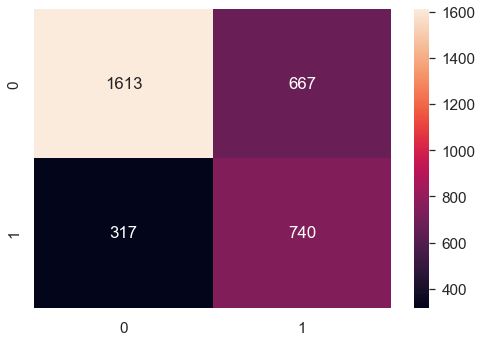


ROC AUC: 
0.7058


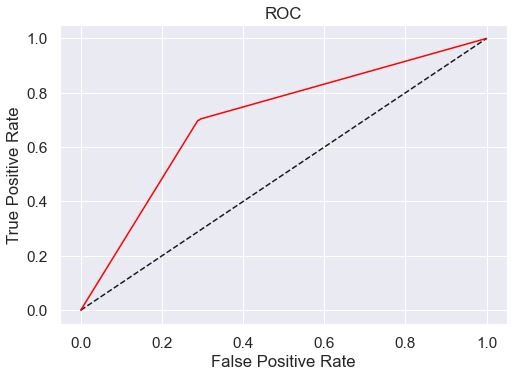


 ***** End of model ***** 



In [87]:
model_result("Decision Tree")

### Model 6: Random Forest


 ***** Model: Random Forest *****

 ***** Model: RandomForestClassifier(random_state=42) *****

Model Accuracy: 
78.03%

CV Result: 
[0.77089202 0.81220657 0.80733083 0.79041353 0.81954887 0.8693609
 0.85996241 0.87406015 0.85056391 0.86090226]

Average CV Score: 
0.8315

Confusion matrix: 
 [[1929  351]
 [ 382  675]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2280
           1       0.66      0.64      0.65      1057

    accuracy                           0.78      3337
   macro avg       0.75      0.74      0.74      3337
weighted avg       0.78      0.78      0.78      3337



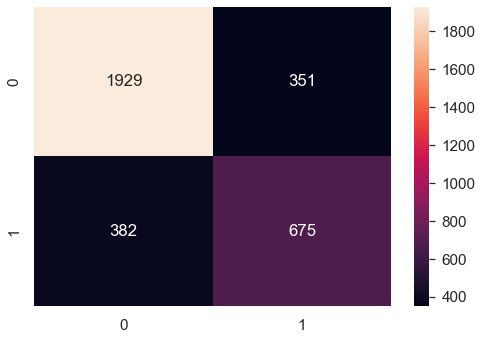


ROC AUC: 
0.8211


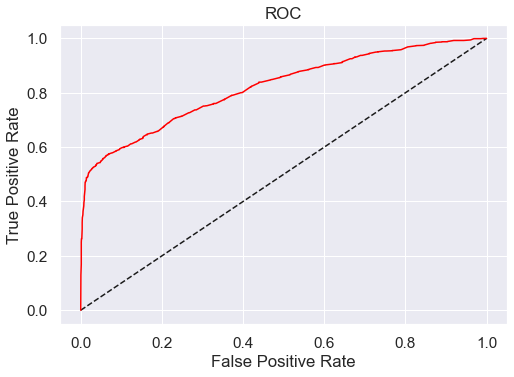


 ***** End of model ***** 



In [88]:
model_result("Random Forest")

### Model 7: XG Boost

[17:46:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

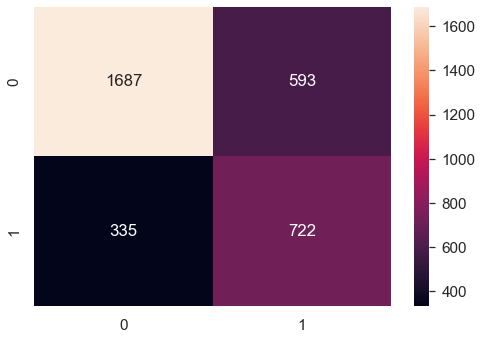


ROC AUC: 
0.7808


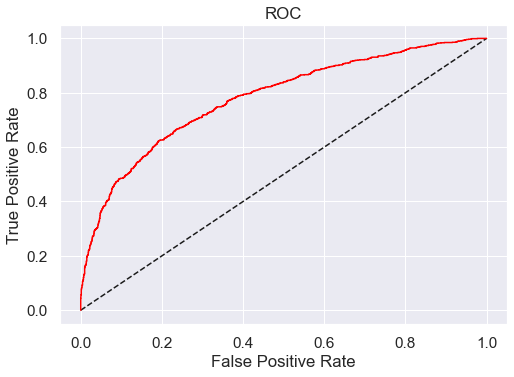


 ***** End of model ***** 



In [83]:
model_result("XG Boost")

### Model 8: AdaBoost


 ***** Model: Ada Boost *****

 ***** Model: AdaBoostClassifier(random_state=42) *****

Model Accuracy: 
57.15%

CV Result: 
[0.56807512 0.60751174 0.58176692 0.6156015  0.64379699 0.69078947
 0.68045113 0.69548872 0.63533835 0.65883459]

Average CV Score: 
0.6378

Confusion matrix: 
 [[1236 1044]
 [ 386  671]]

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.54      0.63      2280
           1       0.39      0.63      0.48      1057

    accuracy                           0.57      3337
   macro avg       0.58      0.59      0.56      3337
weighted avg       0.64      0.57      0.59      3337



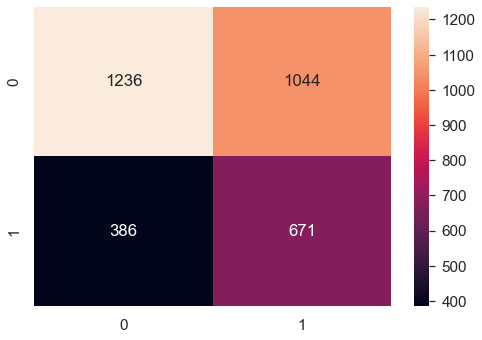


ROC AUC: 
0.6351


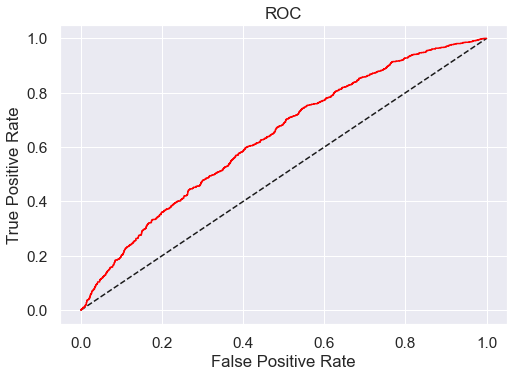


 ***** End of model ***** 



In [89]:
model_result("Ada Boost")

### Model 9: Light GBM


 ***** Model: LightGBM *****

 ***** Model: LGBMClassifier(random_state=42) *****

Model Accuracy: 
69.58%

CV Result: 
[0.68638498 0.72018779 0.70206767 0.71240602 0.72086466 0.80545113
 0.79135338 0.78947368 0.76221805 0.78853383]

Average CV Score: 
0.7479

Confusion matrix: 
 [[1661  619]
 [ 396  661]]

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      2280
           1       0.52      0.63      0.57      1057

    accuracy                           0.70      3337
   macro avg       0.66      0.68      0.67      3337
weighted avg       0.72      0.70      0.70      3337



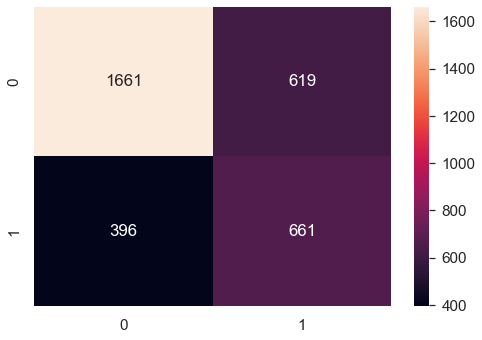


ROC AUC: 
0.7525


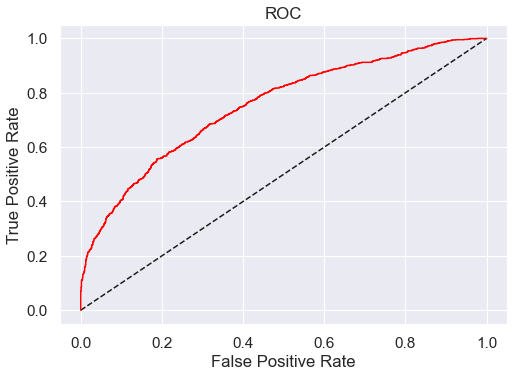


 ***** End of model ***** 



In [90]:
model_result("LightGBM")

### Model 10: Gradient Tree Boosting


 ***** Model: Gradient Tree Boosting *****

 ***** Model: GradientBoostingClassifier(random_state=42) *****

Model Accuracy: 
60.440000000000005%

CV Result: 
[0.60938967 0.63849765 0.6343985  0.64473684 0.67011278 0.73214286
 0.71616541 0.72368421 0.68045113 0.68984962]

Average CV Score: 
0.6739

Confusion matrix: 
 [[1305  975]
 [ 345  712]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.57      0.66      2280
           1       0.42      0.67      0.52      1057

    accuracy                           0.60      3337
   macro avg       0.61      0.62      0.59      3337
weighted avg       0.67      0.60      0.62      3337



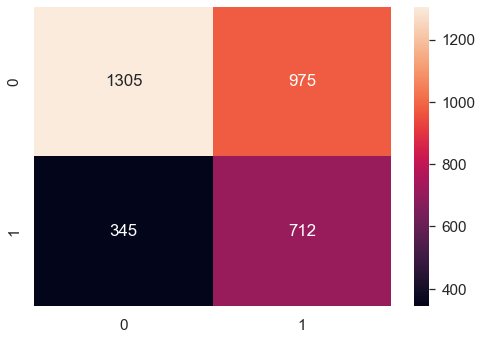


ROC AUC: 
0.6769


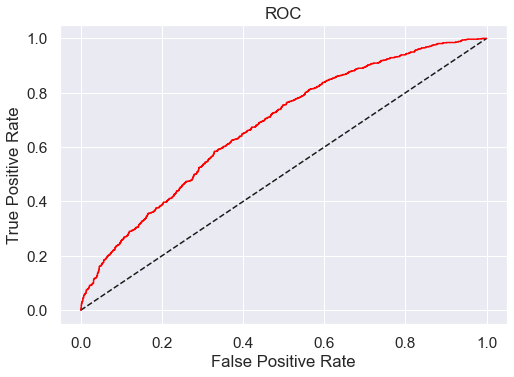


 ***** End of model ***** 



In [91]:
model_result("Gradient Tree Boosting")

## Summary of results of models with default settings

In [93]:
# Create a table of the results
df_results = pd.DataFrame({
    'Model Name': model_names_list,
    'Accuracy': model_accuracy_list,
    'CV Score': model_cv_list,
    'ROC AUC': model_auc_list
})
df_results = df_results.sort_values(by=['ROC AUC'], ascending=False)
df_results.reset_index(drop=True)

Model Name  Accuracy  CV Score  ROC AUC
0           Random Forest    0.7803    0.8315   0.8211
1                XG Boost    0.7219    0.7784   0.7808
2                LightGBM    0.6958    0.7479   0.7525
3     K-Nearest Neighbors    0.6266    0.7288   0.7095
4           Decision Tree    0.7051    0.7450   0.7058
5  Gradient Tree Boosting    0.6044    0.6739   0.6769
6               Ada Boost    0.5715    0.6378   0.6351
7     Logistic Regression    0.5547    0.6026   0.6238
8                     SVM    0.4777    0.5842   0.6221
9             Naive Bayes    0.5043    0.5954   0.6185

## Tuning the Random Forest Hyperparameters

In [94]:
def gridsearch_cv(model, param_grid, cv):

    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)

    # summarize results
    print(f'\n ***** Model: {model} *****\n')
    print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print("\n The best estimator across ALL searched params:\n", grid_result.best_estimator_)
    print("")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # Print performance of each iteration
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

#### Pass 1 - Tuning 'n_estimators' and 'max_features'
Due to computational limitations, I am going to take 1-2 features at a time and run them through GridSearchCV

In [909]:
# define models and parameters
model = RandomForestClassifier(max_depth=None, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=random_state)

# Pass 1: Paramater grid for running grid seach
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt']
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=42) *****

Best Score: 0.918788 using {'max_depth': 50, 'max_features': 'auto'}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=400,
                       random_state=42)

0.820239 (0.038538) with: {'max_depth': 10, 'max_features': 'auto'}
0.820239 (0.038538) with: {'max_depth': 10, 'max_features': 'sqrt'}
0.908806 (0.038531) with: {'max_depth': 20, 'max_features': 'auto'}
0.908806 (0.038531) with: {'max_depth': 20, 'max_features': 'sqrt'}
0.918082 (0.037290) with: {'max_depth': 30, 'max_features': 'auto'}
0.918082 (0.037290) with: {'max_depth': 30, 'max_features': 'sqrt'}
0.918486 (0.037833) with: {'max_depth': 40, 'max_features': 'auto'}
0.918486 (0.037833) with: {'max_depth': 40, 'max_features': 'sqrt'}
0.918788 (0.037751) with: {'max_depth': 50, 'max_features': 'auto'}
0.918788 (0.037751) with: {'max_depth': 50, 'max_features':

#### Pass 2 - Tuning 'n_estimators'


In [911]:
# Pass 2
# Pass 1: Best Score: 0.918788 using {'max_depth': 50, 'max_features': 'auto'}
model = RandomForestClassifier(max_depth=50, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, max_features='auto', random_state=random_state)

# Pass 2: Paramater grid for running grid seach
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200]
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=400,
                       random_state=42) *****

Best Score: 0.918876 using {'n_estimators': 800}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=800,
                       random_state=42)

0.917998 (0.037130) with: {'n_estimators': 200}
0.918788 (0.037751) with: {'n_estimators': 400}
0.918712 (0.037873) with: {'n_estimators': 600}
0.918876 (0.037841) with: {'n_estimators': 800}
0.918766 (0.037923) with: {'n_estimators': 1000}
0.918761 (0.037949) with: {'n_estimators': 1200}


Increasing the number of estimators does improve the model AUC score. However, it also increases the time complexity significantly. As a result, I have take the number of estimators to be 400 as the gain from 400 to 800 is 0.9187 to 0.9188, which is not very significant and I am willing to make that trade-off.

#### Pass 3 - Tuning 'min_samples_leaf' and 'min_samples_split'


In [912]:
# Pass 3
# Pass 1 - Best Score: 0.918508 using {'max_depth': 40, 'max_features': 'auto'}
# Pass 2 - Best Score: 0.918876 using {'n_estimators': 400} # The gain from increasing estimators from 400 to 800 is very little (0.9187 to 0.9188), hence the n_estimator is being set to 400

model = RandomForestClassifier(max_depth=50, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, max_features='auto', random_state=random_state)

# Pass 2: Paramater grid for running grid seach
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
 }

gridsearch_cv(model, param_grid, 10)


 ***** Model: RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=400,
                       random_state=42) *****

Best Score: 0.918788 using {'min_samples_leaf': 1, 'min_samples_split': 2}

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=400,
                       random_state=42)

0.918788 (0.037751) with: {'min_samples_leaf': 1, 'min_samples_split': 2}
0.918633 (0.037499) with: {'min_samples_leaf': 1, 'min_samples_split': 3}
0.917587 (0.037719) with: {'min_samples_leaf': 1, 'min_samples_split': 4}
0.915391 (0.037378) with: {'min_samples_leaf': 2, 'min_samples_split': 2}
0.915391 (0.037378) with: {'min_samples_leaf': 2, 'min_samples_split': 3}
0.915391 (0.037378) with: {'min_samples_leaf': 2, 'min_samples_split': 4}
0.910895 (0.038797) with: {'min_samples_leaf': 3, 'min_samples_split': 2}
0.910895 (0.038797) with: {'min_samples_leaf': 3, 'min_samples_split': 3}
0.910895 (0.038797) with: {'min_samp

### Tuned Random Forest


 ***** Tuned Model: RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=400,
                       random_state=42) *****

Model Accuracy: 
79.08%

Average CV Score: 
0.8472

ROC AUC: 
0.822


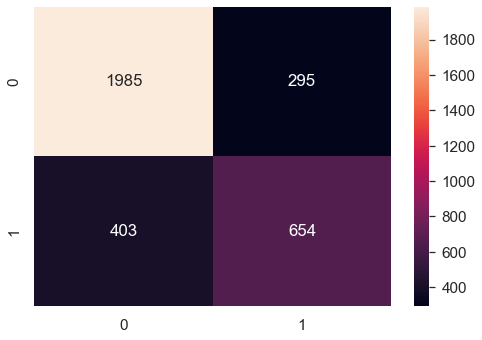

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Confusion matrix: 
 [[1985  295]
 [ 403  654]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      2280
           1       0.69      0.62      0.65      1057

    accuracy                           0.79      3337
   macro avg       0.76      0.74      0.75      3337
weighted avg       0.79      0.79      0.79      3337



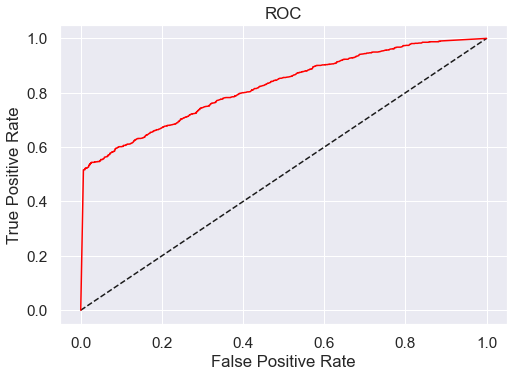

In [41]:
# Run Random Forest with tuning
model_rf = RandomForestClassifier(max_depth=50, n_estimators=400, criterion='gini', min_samples_leaf=1, min_samples_split=2, bootstrap=False, max_features='auto', random_state=random_state)

model_rf.fit(X_train, y_train)

# Predict the output on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate accuracy
acc_score_rf = round(accuracy_score(y_test, y_pred_rf),4)

# Calculate CV result
cv_result_rf = cross_val_score(model_rf, X_train, y_train, cv=10, scoring='accuracy')

# ROC AUC Score
y_pred_prob_rf = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = round(auc(fpr_rf, tpr_rf), 4)

# Print the model results
print(f'\n ***** Tuned Model: {model_rf} *****')
print(f'\nModel Accuracy: \n{acc_score_rf*100}%')
print(f'\nAverage CV Score: \n{round(np.average(cv_result_rf), 4)}')
print(f'\nROC AUC: \n{round(roc_auc_rf, 4)}')

# Get confusion matrix
cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

# Get classification report
cr_model = classification_report(y_true=y_test, y_pred=y_pred_rf)

sns.heatmap(cm_model,annot=True,fmt="d")
plt.show()
print('\nConfusion matrix: \n',cm_model)
print('\nClassification report: \n',cr_model)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

## Tuning XGB Classifier hyperparameters

#### Pass 1 - Tuning 'n_estimators', 'learning_rate', and 'max_depth'


In [101]:
# XGBoost tuning - Pass 1
model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state, use_label_encoder=False)

param_grid = {
    'max_depth': range (3, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

gridsearch_cv(model, param_grid, 10)


[19:17:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

#### Pass 2 - Tuning 'gamma' and 'min_child_weight'


In [96]:
# XGBoost tuning - Pass 2
# Pass 1: Best Score: 0.888731 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
model = XGBClassifier( learning_rate =0.1, n_estimators=180, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state, use_label_encoder=False)

# Pass 3
param_grid = {
    'gamma':[i/10.0 for i in range(0,5)],
    'min_child_weight': [1,2,3]
}

gridsearch_cv(model, param_grid, 10)


[18:39:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 ***** Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=None) *****

Best Score: 0.889042 using {'gamma'

#### Pass 3 - Tuning 'col_sample_bytree' and 'subsample'


In [98]:
# XGBoost tuning - Pass 3
# Pass 1: Best Score: 0.888731 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
# Pass 2: Best Score: 0.889042 using {'gamma': 0.2, 'min_child_weight': 1}
model = XGBClassifier( learning_rate =0.1, n_estimators=180, max_depth=9, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state, use_label_encoder=False)

# Pass 3
param_grid = {
    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9]
}

gridsearch_cv(model, param_grid, 10)


[19:00:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 ***** Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, ...) *****

Best Sc

### Tuned Model - XGB Classifier

[19:10:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:11:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

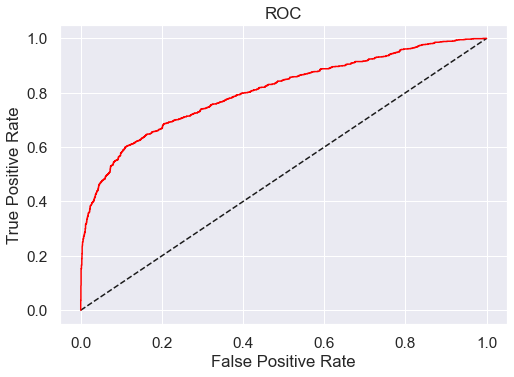

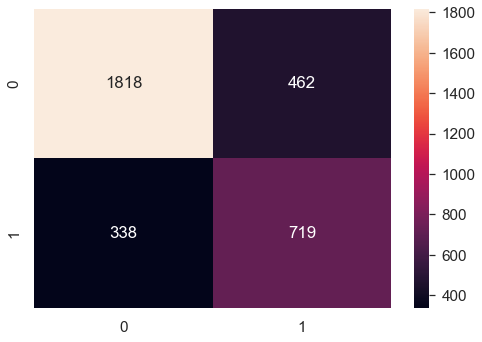


Confusion matrix: 
 [[1818  462]
 [ 338  719]]

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      2280
           1       0.61      0.68      0.64      1057

    accuracy                           0.76      3337
   macro avg       0.73      0.74      0.73      3337
weighted avg       0.77      0.76      0.76      3337



In [100]:
## XGBoost with tuning
# Pass 1: Best Score: 0.888731 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
# Pass 2: Best Score: 0.889042 using {'gamma': 0.2, 'min_child_weight': 1}
# Pass 3: Best Score: 0.889773 using {'colsample_bytree': 0.9, 'subsample': 0.8}
model_xgb = XGBClassifier( learning_rate =0.1, n_estimators=180, max_depth=9, min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.9, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_state, use_label_encoder=False)

model_xgb.fit(X_train, y_train, eval_metric='rmse')

# Predict the output on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Calculate accuracy
acc_score_xgb = round(accuracy_score(y_test, y_pred_xgb),4)

# Calculate CV result
cv_result_xgb = cross_val_score(model_xgb, X_train, y_train, cv=10, scoring='accuracy')

# Print the model results
print(f'\n ***** Tuned Model: {model_xgb} *****')
print(f'\nModel Accuracy: \n{acc_score_xgb*100}%')
print(f'\nAverage CV Score: \n{round(np.average(cv_result_xgb), 4)}')

y_pred_prob_xgb = model_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = round(auc(fpr_xgb, tpr_xgb), 4)
print(f'\nROC Score: \n{roc_auc_xgb}')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

# Get confusion matrix
cm_model = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)

# Get classification report
cr_model = classification_report(y_true=y_test, y_pred=y_pred_xgb)

sns.heatmap(cm_model,annot=True,fmt="d")
plt.show()
print('\nConfusion matrix: \n',cm_model)
print('\nClassification report: \n',cr_model)

#### ROC Curve Comparison for the tuned models

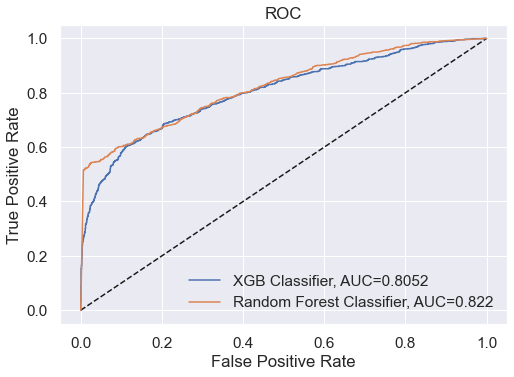

In [69]:

# Plot ROC curve for the tuned models

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label="XGB Classifier, AUC="+str(roc_auc_xgb))
plt.plot(fpr_rf, tpr_rf, label="Random Forest Classifier, AUC="+str(roc_auc_rf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

## Feature Importance

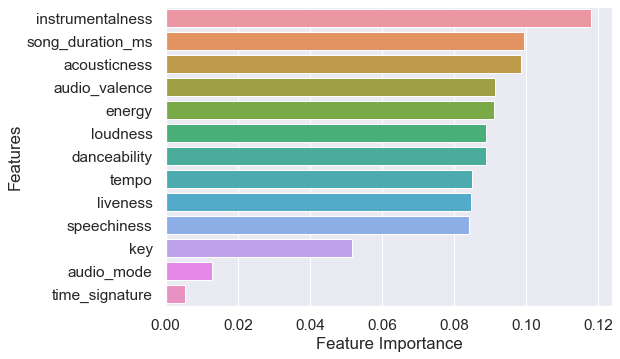

In [916]:
model_name = "Random Forest"
#model, acc_model, cv_result, y_pred = create_model(model_name)

fi = model_rf.feature_importances_

# CReate a dataframe with 2 arrays
df_features = pd.DataFrame({
    'feature_name': X_train.columns,
    'importance': model_rf.feature_importances_
})
df_features = df_features.sort_values(by=['importance'], ascending=False)
df_features.head()

sns.barplot(x='importance', y='feature_name', data=df_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()